In [406]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(torch.__version__)

2.3.0


In [407]:
# Is MPS even available? macOS 12.3+
print(torch.backends.mps.is_available())

# Was the current version of PyTorch built with MPS activated?
print(torch.backends.mps.is_built())

True
True


In [408]:
from sklearn.datasets import make_circles

# make 100 samples
n = 1000

# create circles
X, y = make_circles(n_samples=n, noise=0.03, random_state=42)

len(X), len(y)

(1000, 1000)

In [409]:
# create a DataFrame
circles = pd.DataFrame(dict(x1=X[:,0], x2=X[:,1], label=y))

In [410]:
circles.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


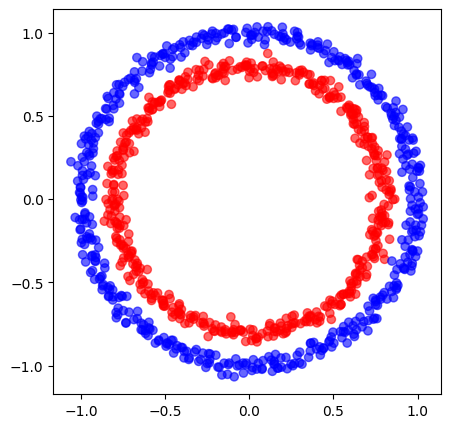

In [411]:
# visualize the data
plt.figure(figsize=(5, 5))
plt.scatter(circles.x1, circles.x2, c=circles.label, cmap='bwr', alpha=0.6)

In [412]:
# checking input and output shapes
X.shape, y.shape

((1000, 2), (1000,))

In [413]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [414]:
# turning the data into PyTorch tensors and doing train test split
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [415]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [416]:
torch.manual_seed(42)

In [417]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [418]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [419]:
# Building model
from torch import nn

class CircleModel_V0(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=10) 
        self.fc2 = nn.Linear(in_features=10,out_features=10)
        self.fc3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model_0 = CircleModel_V0()

In [420]:
model_0

CircleModel_V0(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

**note** -> we can use nn.Sequential() to build our model as well

In [421]:
model_0.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('fc1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('fc2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000

In [422]:
# making predictions on untrained network
with torch.inference_mode():
    untrained_preds = model_0(X_test)
    untrained_preds[:5]

In [423]:
untrained_preds[:5]

tensor([[0.5042],
        [0.5052],
        [0.5032],
        [0.5043],
        [0.5105]])

In [424]:
X_test.shape

torch.Size([200, 2])

In [425]:
# setting up loss function and optimizer
loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.03)

In [426]:
# performance metric
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

**Note** -> Logits are the raw output of the model without passing it through any activation functions

In [427]:
# model training
torch.manual_seed(42)
epochs = 200 

# building training and evaluation loop
for epoch in range(epochs):

    # ----------  training loop  ------------
    model_0.train()

    # forward pass
    y_pred_prob = model_0(X_train).squeeze()
    y_pred = torch.round(y_pred_prob) # logits -> pred_probs -> labels

    # calculate loss/accuracy
    loss = loss_fn(y_pred, y_train)

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    # backpropogation
    loss.backward()

    # optimizer step
    optimizer.step()

    #  ----------  testing loop  ------------
    model_0.eval()

    with torch.inference_mode():
        # forward pass
        y_pred_prob_test = model_0(X_test).squeeze()
        y_pred_test = torch.round(y_pred_prob_test)

        # calculate loss/accuracy
        loss_test = loss_fn(y_pred_prob_test, y_test)
        acc_test = accuracy_fn(y_true=y_test, y_pred=y_pred_test)

    # print out what's happening
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss:.4f}, Acc: {acc:.4f}, Test Loss: {loss_test:.4f}, Test Acc: {acc_test:.4f}')

Epoch [0/200], Loss: 50.0000, Acc: 50.0000, Test Loss: 0.6933, Test Acc: 50.0000
Epoch [100/200], Loss: 50.0000, Acc: 50.0000, Test Loss: 0.6933, Test Acc: 50.0000


In [428]:
# m